In [ ]:
import os
os.chdir('../')

In [85]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import bisect 
from numpy import sqrt, cosh, cos, sinh

from utils.root2df import Root2Df
import xgboost as xgb

import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Rectangle
from sklearn.ensemble import RandomForestClassifier

In [260]:
sns.set_style()

In [2]:
res = Root2Df(data_dir=Path('../data/raw')).read_df()
res.keys()

[INFO] Reading skim configuration file: ..\data\raw\processing.cfg
[INFO] ..\data\raw\MinBiasPU140_MTD.root loaded!
[INFO] ..\data\raw\MinBiasPU200_MTD.root loaded!
[INFO] ..\data\raw\MinBiasPU250_MTD.root loaded!
[INFO] ..\data\raw\DsTau3muPU0_MTD.root loaded!
[INFO] ..\data\raw\DsTau3muPU200_MTD.root loaded!


dict_keys(['MinBiasPU140_MTD', 'MinBiasPU200_MTD', 'MinBiasPU250_MTD', 'DsTau3muPU0_MTD', 'DsTau3muPU200_MTD'])

In [3]:
neg200 = res['MinBiasPU200_MTD']
pos0 = res['DsTau3muPU0_MTD']
pos200 = res['DsTau3muPU200_MTD']
print(len(neg200), len(pos0), len(pos200))
pos0 = pos0[pos0.n_gen_tau == 1].reset_index(drop=True)
pos200 = pos200[pos200.n_gen_tau == 1].reset_index(drop=True)
print(len(neg200), len(pos0), len(pos200))

499600 600000 100000
499600 466320 77883


In [17]:
all_eta = [eta for each in pos200.apply(lambda x: x['mu_hit_sim_eta'] \
                                        [(x['mu_hit_station']==1) * (x['mu_hit_neighbor']==0)], axis=1) for eta in each]
all_eta += [eta for each in neg200.apply(lambda x: x['mu_hit_sim_eta'] \
                                         [(x['mu_hit_station']==1) * (x['mu_hit_neighbor']==0)], axis=1) for eta in each]


all_phi = [phi*(math.pi/180) for each in pos200.apply(lambda x: x['mu_hit_sim_phi'] \
                                                      [(x['mu_hit_station']==1) * (x['mu_hit_neighbor']==0)],
                                                      axis=1) for phi in each]
all_phi += [phi*(math.pi/180) for each in neg200.apply(lambda x: x['mu_hit_sim_phi'] \
                                                       [(x['mu_hit_station']==1) * (x['mu_hit_neighbor']==0)], 
                                                       axis=1) for phi in each]

<AxesSubplot:ylabel='Count'>

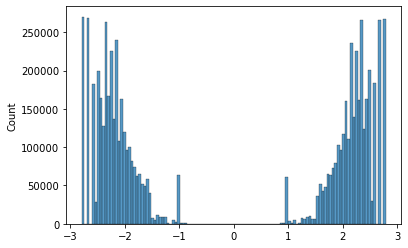

In [18]:
sns.histplot(all_eta)

<AxesSubplot:ylabel='Count'>

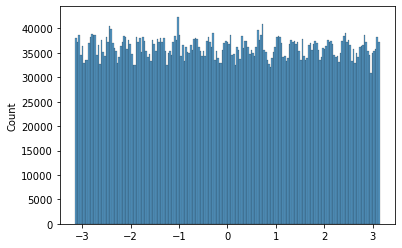

In [19]:
sns.histplot(all_phi)

In [23]:
def get_bins(data, num_bins):
    data = np.sort(data)
    
    bins = []
    for i in range(0, num_bins+1):
        bins.append(np.percentile(data, i * 100 / num_bins))
    return bins, num_bins/100*len(data)

def get_feature_names(eta_bins, phi_bins, num_bins):
    names = []
    figs = []
    for i in range(len(eta_bins) - 1):
        for j in range(len(phi_bins) - 1):
            names.append(f'{len(names)}\n{eta_bins[i]:.2f}<eta<{eta_bins[i+1]:.2f}\n{phi_bins[j]:.2f}<phi<{phi_bins[j+1]:.2f}\n')

            assert (i * num_bins['phi'] + j) == len(names) - 1
            fig = plt.figure(len(names) - 1)
            ax = plt.gca()
            ax.add_patch(Rectangle((eta_bins[i], phi_bins[j]), 
                                   eta_bins[i+1]-eta_bins[i], 
                                   phi_bins[j+1]-phi_bins[j]))
            ax.set_xlim(np.min(eta_bins), np.max(eta_bins))
            ax.set_ylim(np.min(phi_bins), np.max(phi_bins))
            ax.set_xlabel('eta')
            ax.set_ylabel('phi')
            ax.axvline(x=0, ls='--', color='r')
            figs.append(fig)
    return names, figs

def get_cartesian_product(hit_eta, hit_phi, eta_bins, phi_bins, num_bins):
    
    x = np.zeros(num_bins['eta'] * num_bins['phi'])
    
    hit_phi *= math.pi/180
    
    if len(hit_eta) == 0:
        return x
    
    eta_dim = []
    for eta in hit_eta:
        for i in range(len(eta_bins) - 1):
            if eta_bins[i] <= eta <= eta_bins[i+1]:
                eta_dim.append(i)
                break

    phi_dim = []
    for phi in hit_phi:
        for j in range(len(phi_bins) - 1):
            if phi_bins[j] <= phi <= phi_bins[j+1]:
                phi_dim.append(j)     
                break


    product_dim = []
    for i in range(len(eta_dim)):
        product_dim.append(eta_dim[i] * num_bins['phi'] + phi_dim[i])

    for each in product_dim:
        x[each] += 1
    return x

def get_x(df: pd.DataFrame, eta_bins, phi_bins, num_bins):
    all_x = []
    for entry in tqdm(df.itertuples(index=False), total=len(df)):
        idx = (entry.mu_hit_station == 1) * (entry.mu_hit_neighbor == 0)
        
        hit_eta = entry.mu_hit_sim_eta[idx]
        hit_phi = entry.mu_hit_sim_phi[idx]
        x = get_cartesian_product(hit_eta, hit_phi, eta_bins, phi_bins, num_bins)
        
        all_x.append(x)
    return np.stack(all_x)


In [24]:
times = 6
assert len(neg200) > len(pos200) * times

neg_idx = np.arange(len(neg200))
np.random.shuffle(neg_idx)

neg_num = len(pos200) * times
neg_idx = neg_idx[:neg_num]

print('pos2neg:', 1/times)

pos2neg: 0.16666666666666666


<ipython-input-23-c77264a1001e>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(len(names) - 1)


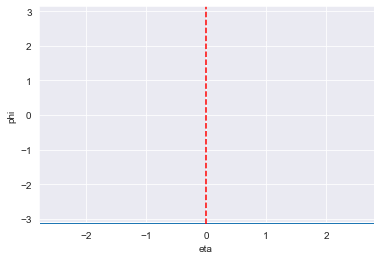

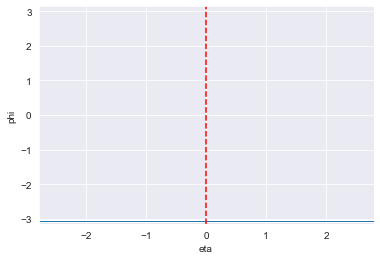

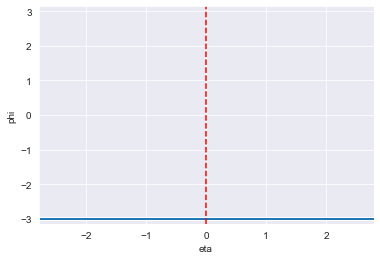

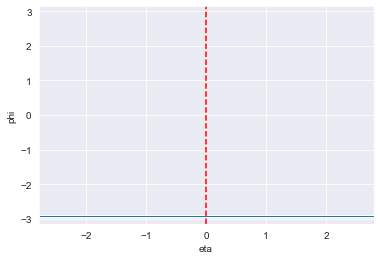

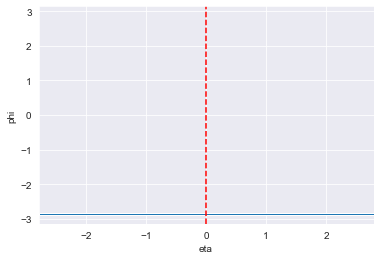

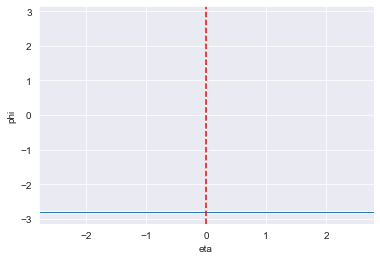

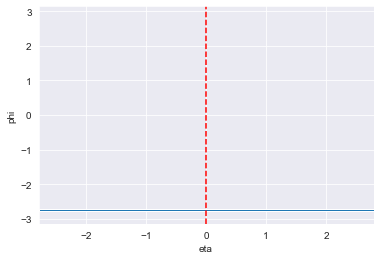

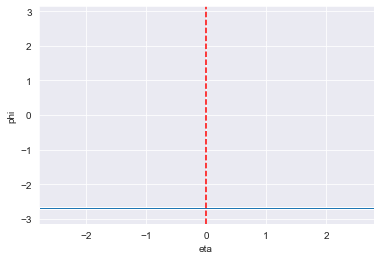

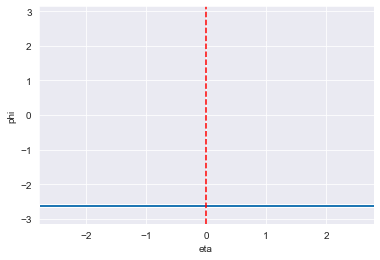

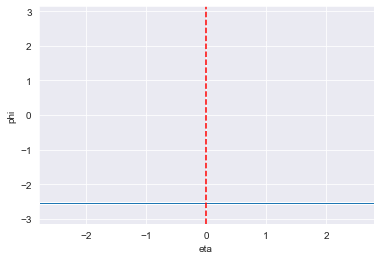

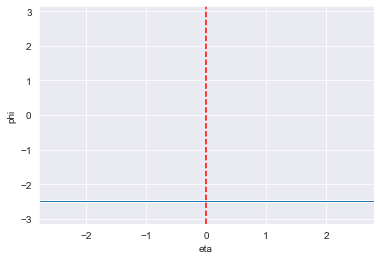

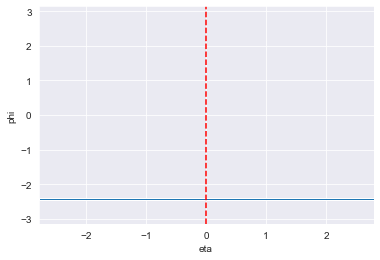

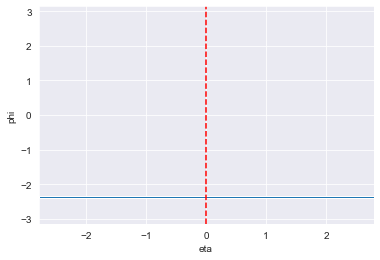

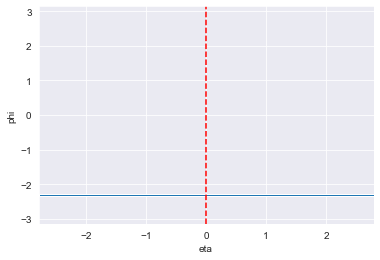

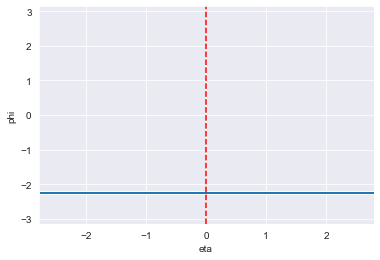

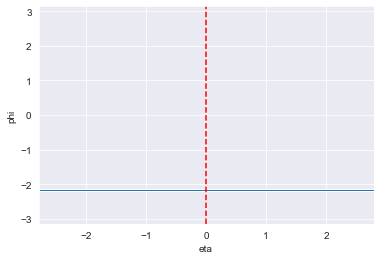

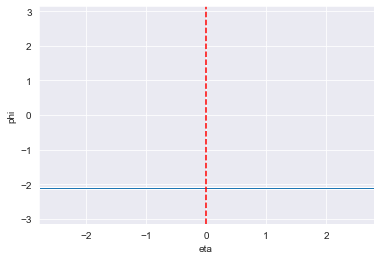

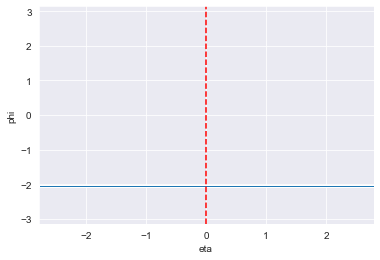

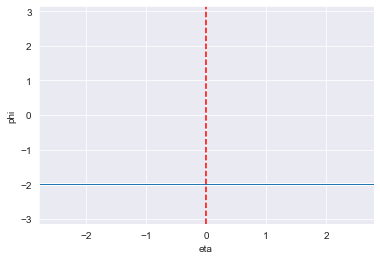

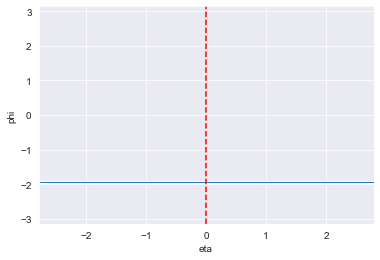

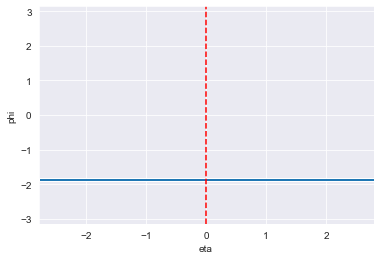

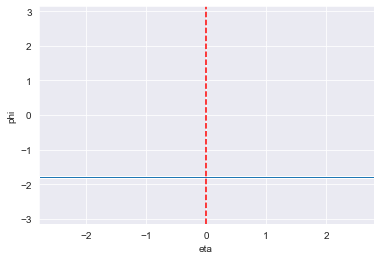

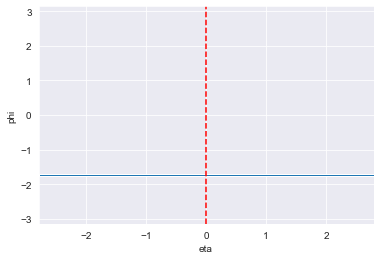

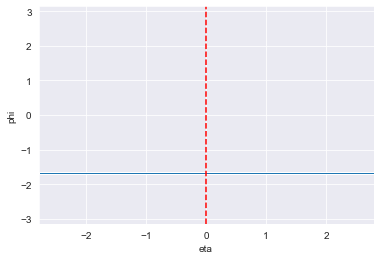

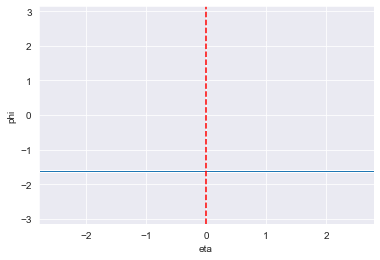

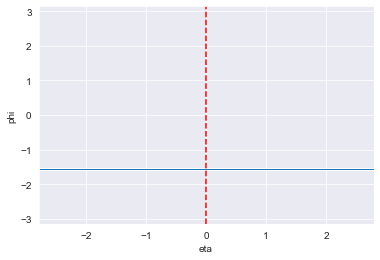

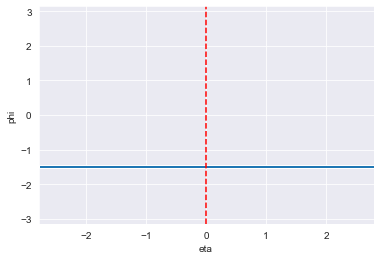

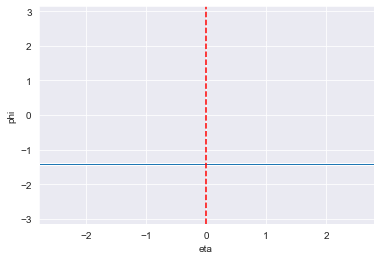

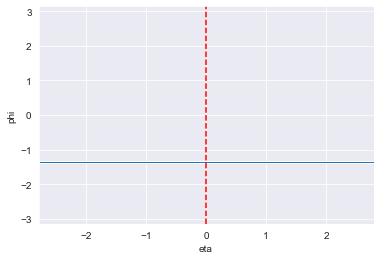

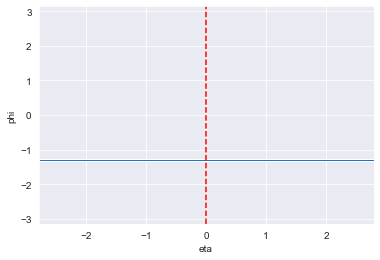

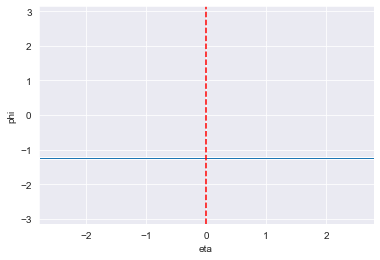

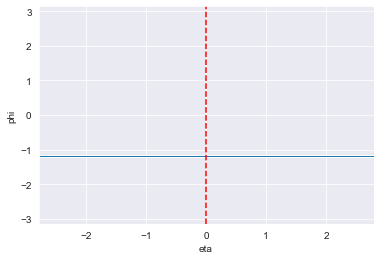

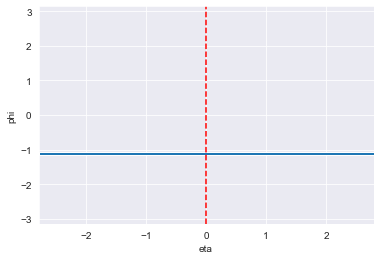

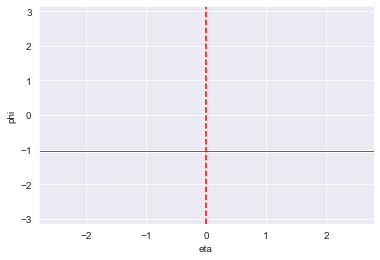

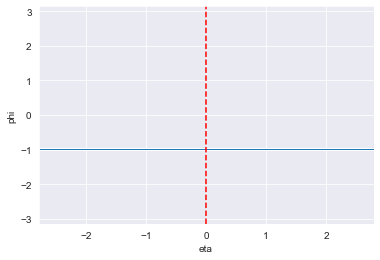

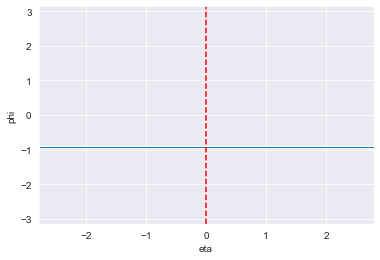

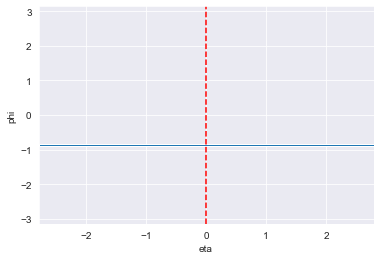

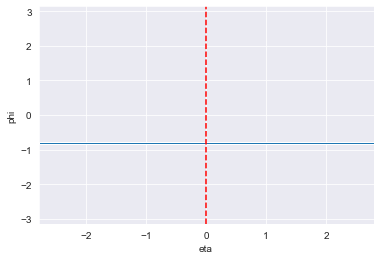

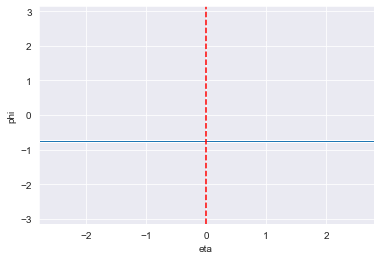

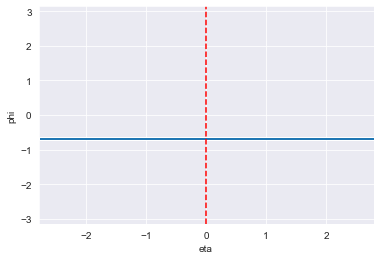

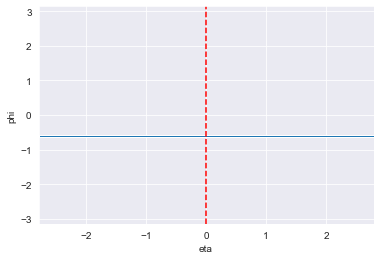

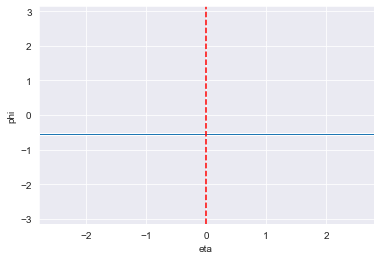

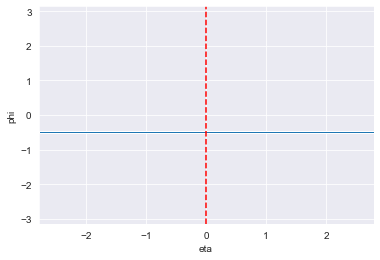

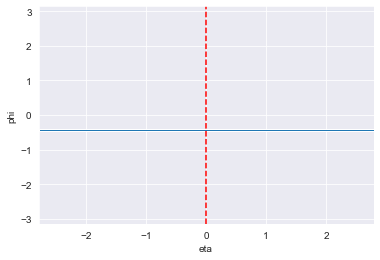

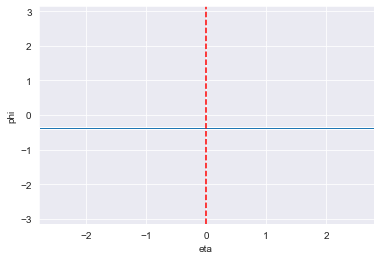

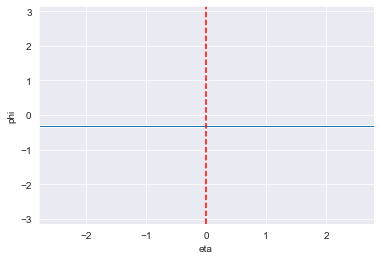

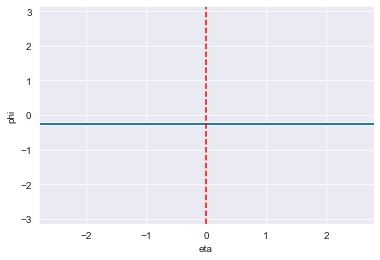

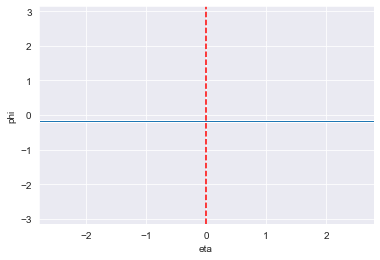

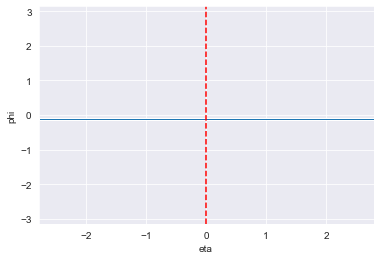

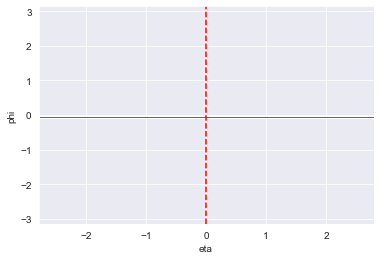

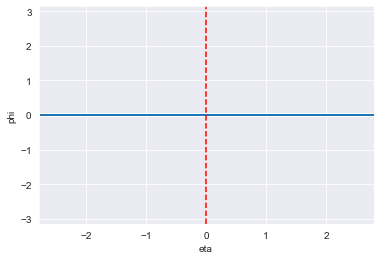

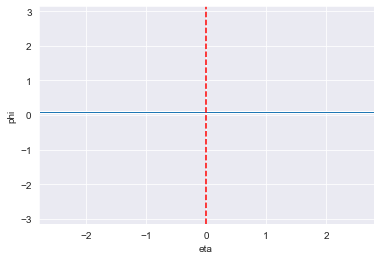

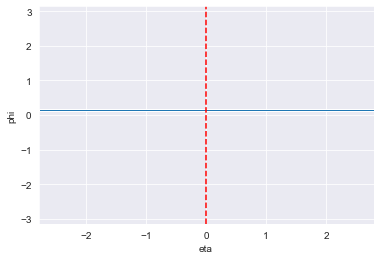

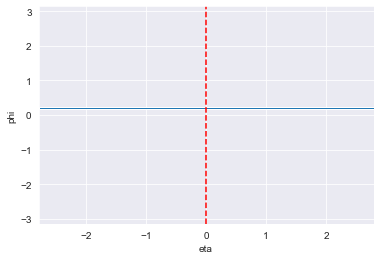

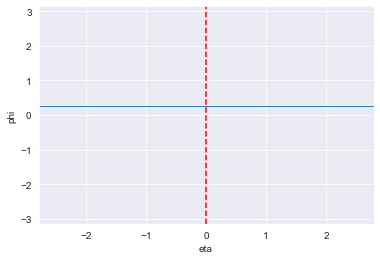

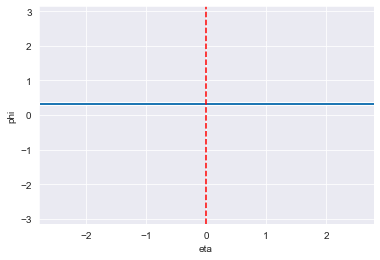

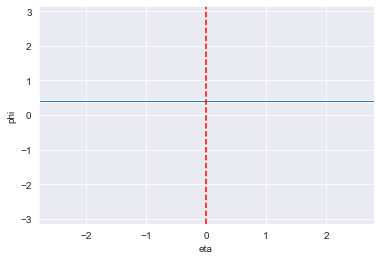

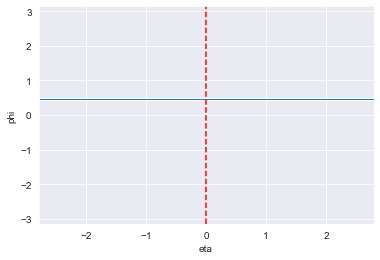

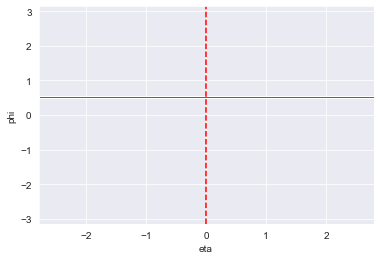

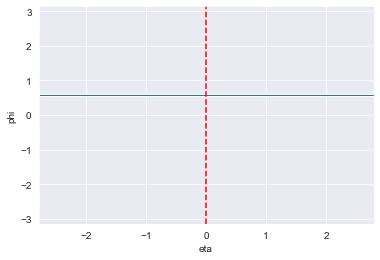

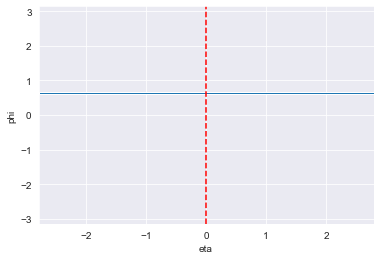

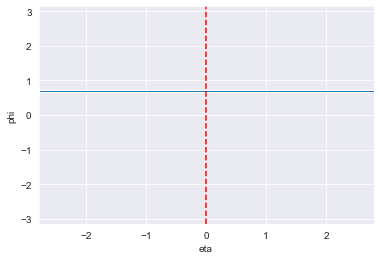

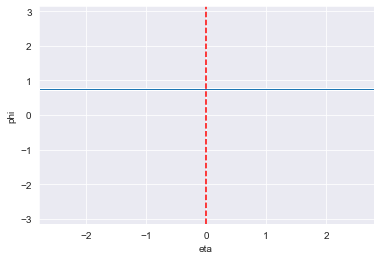

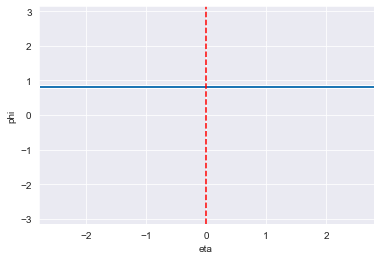

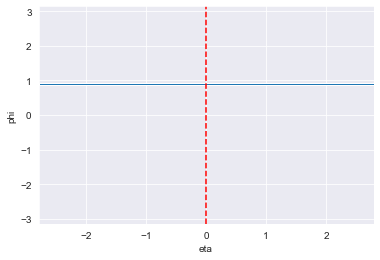

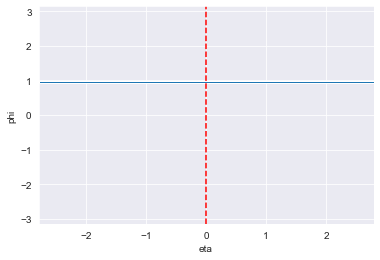

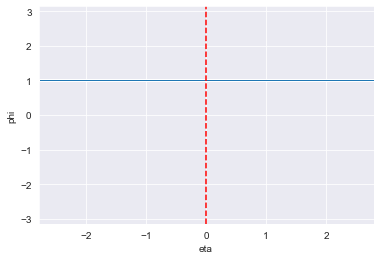

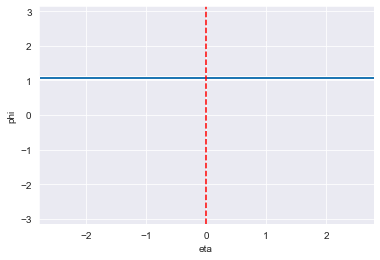

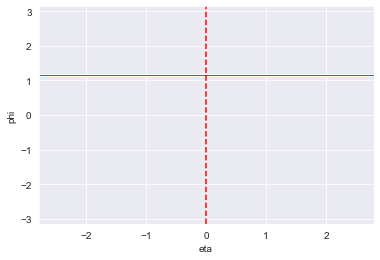

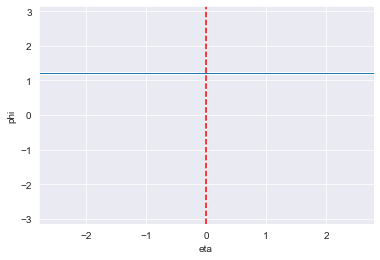

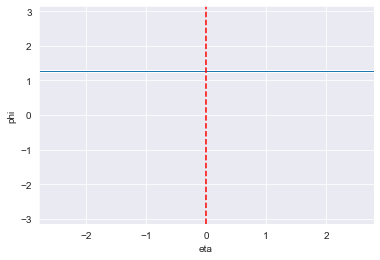

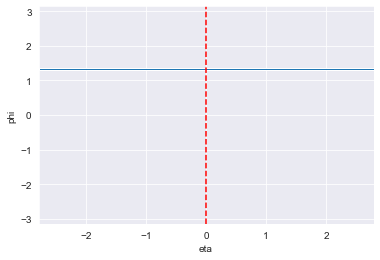

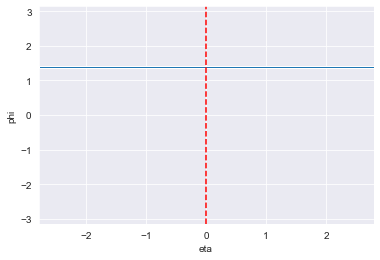

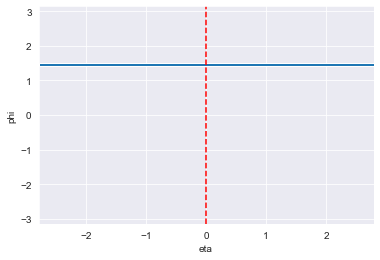

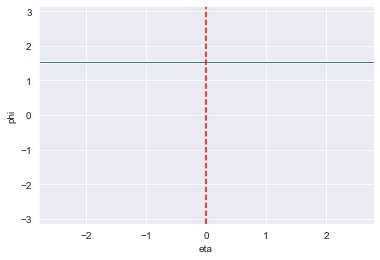

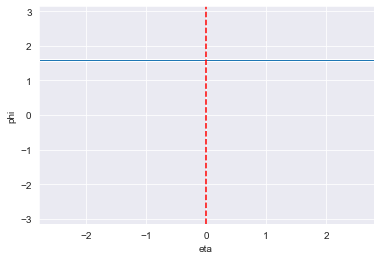

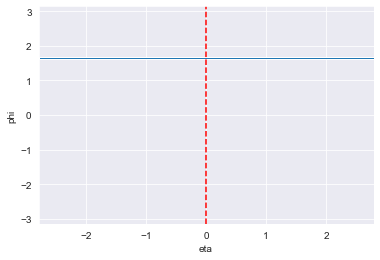

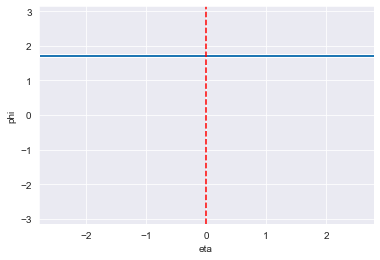

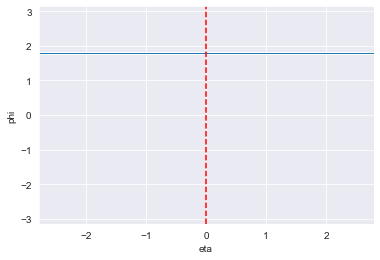

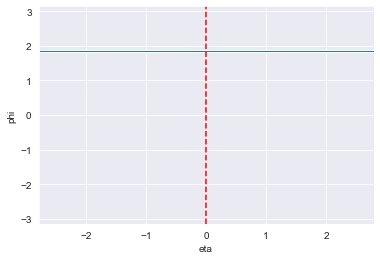

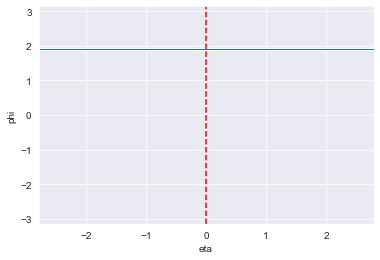

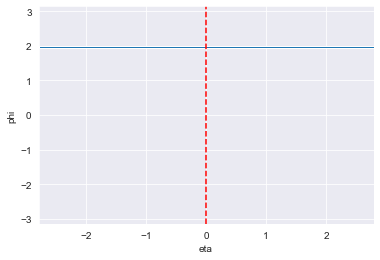

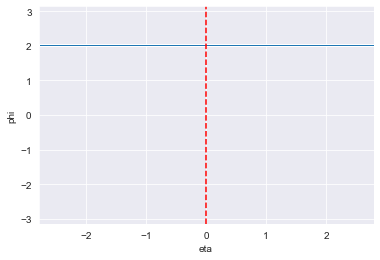

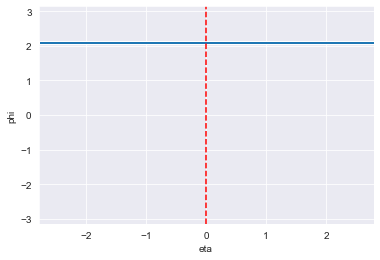

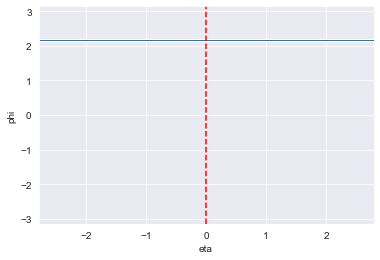

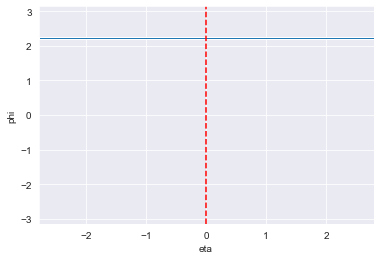

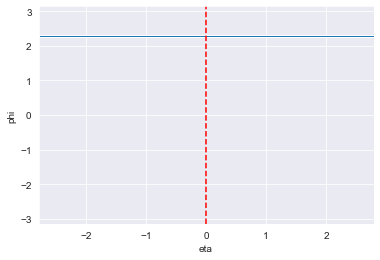

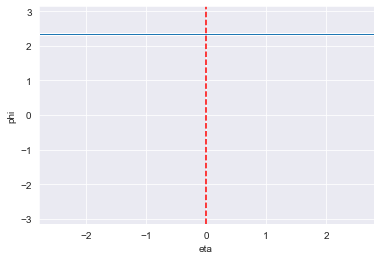

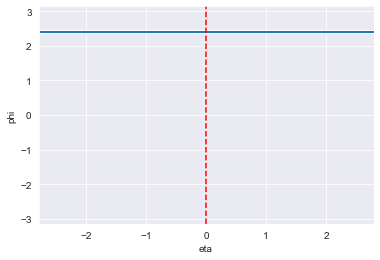

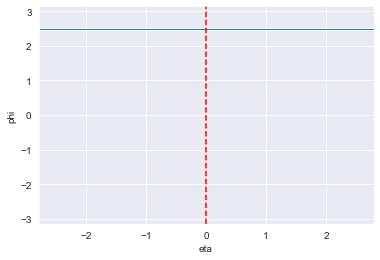

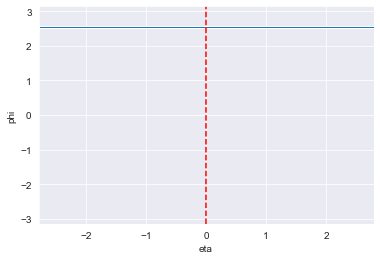

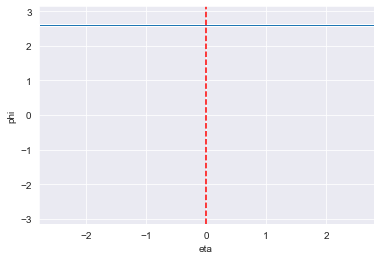

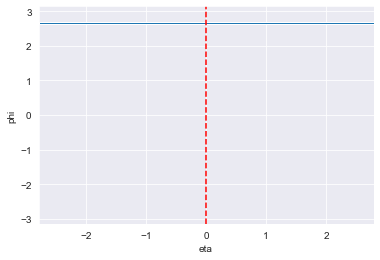

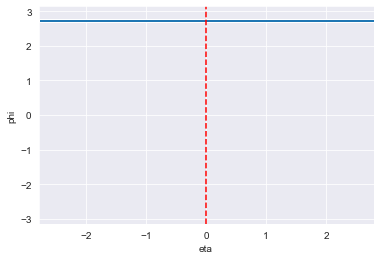

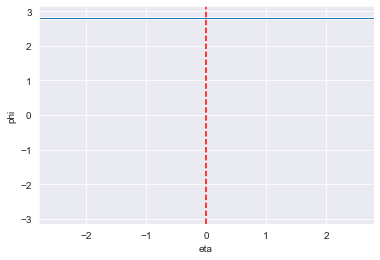

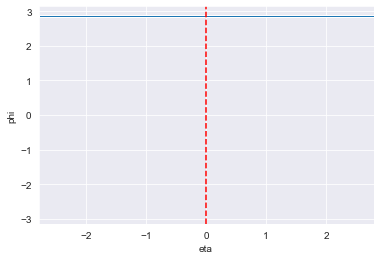

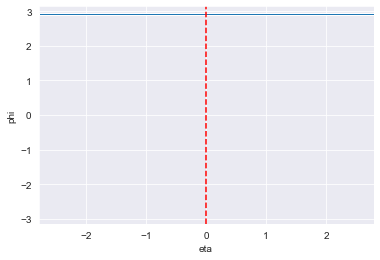

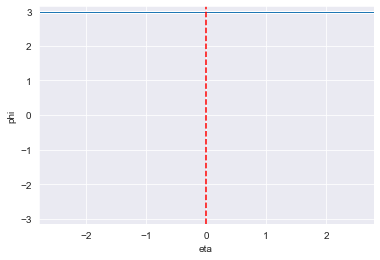

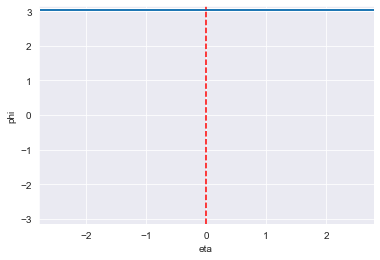

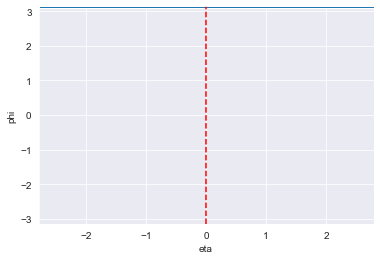

In [237]:
num_bins = {'eta': 1, 'phi': 100}

eta_bins, size_per_eta_bin = get_bins(all_eta, num_bins['eta'])
# if 0.0 not in eta_bins:
#     bisect.insort(eta_bins, 0.0) 
#     num_bins['eta'] += 1

phi_bins, size_per_phi_bin = get_bins(all_phi, num_bins['phi'])
feature_names, figs = get_feature_names(eta_bins, phi_bins, num_bins)

In [238]:
pos_x = get_x(pos200, eta_bins, phi_bins, num_bins)
pos_y = np.ones((pos_x.shape[0]))

neg_x = get_x(neg200, eta_bins, phi_bins, num_bins)
neg_y = np.zeros((neg_x.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499600/499600 [07:02<00:00, 1182.66it/s]


In [239]:
x = np.concatenate((pos_x, neg_x))
y = np.concatenate((pos_y, neg_y))

In [240]:
idx = np.arange(x.shape[0])
np.random.shuffle(idx)

In [241]:
x = x[idx]
y = y[idx]

In [242]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [267]:
# clf = tree.DecisionTreeClassifier(max_depth=30, criterion='entropy',
#                                   min_samples_leaf=10,
#                                   min_samples_split=5)


clf = tree.DecisionTreeClassifier()


# clf = RandomForestClassifier(n_estimators=50, n_jobs=8)


# clf = LogisticRegression()


# param_dist = {'objective':'binary:logistic', 'n_estimators':2000}
# clf = xgb.XGBModel(**param_dist)

In [268]:
clf = clf.fit(X_train, y_train)

In [269]:
pred_y_test = clf.predict(X_test)
pred_y_train = clf.predict(X_train)

auroc: 0.9992302052298346
acc: 0.9997798326728313


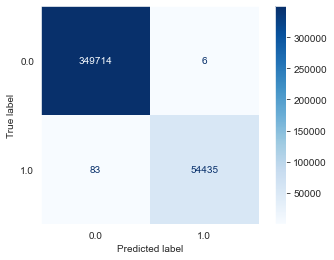

In [270]:
print('auroc:', roc_auc_score(y_train, pred_y_train))
print('acc:',(y_train == (pred_y_train > 0.5) ).sum() / len(y_train))
disp = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Blues)

auroc: 0.8549536840400346
acc: 0.9245577072931398


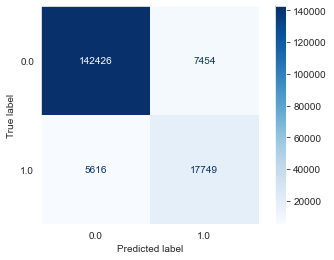

In [271]:
print('auroc:', roc_auc_score(y_test, pred_y_test))
print('acc:',(y_test == (pred_y_test > 0.5)).sum() / len(y_test))
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)

In [272]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test)
fpr *= 31000
fpr, tpr

(array([    0.        ,  1541.72671471, 31000.        ]),
 array([0.        , 0.75964049, 1.        ]))

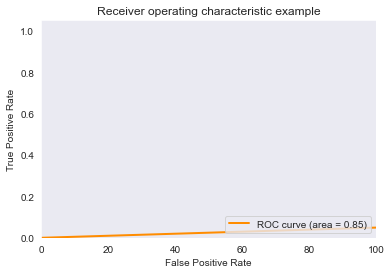

In [273]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred_y_test))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 100])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [274]:
sns.set_style("dark")
fig = plt.figure(figsize=(200, 100))
tree.plot_tree(clf, filled=True, max_depth=5, impurity=False, proportion=False,
               class_names=['Bkg', 'Signal'],
               feature_names=feature_names)
fig.savefig("./trees/decistion_tree.png")

In [98]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_indicator = clf.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = clf.apply(X_test)
yyy = clf.predict(X_test)



# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

# HERE IS WHAT YOU WANT
sample_id = 100
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:

    if leave_id[sample_id] == node_id:  # <-- changed != to ==
        #continue # <-- comment out
        print("leaf node {} reached, no decision here".format(leave_id[sample_id])) # <--

    else: # < -- added else to iterate through decision nodes
        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
              % (node_id,
                 sample_id,
                 feature[node_id],
                 X_test[sample_id, feature[node_id]], # <-- changed i to sample_id
                 threshold_sign,
                 threshold[node_id]))
print('pred_y', yyy[sample_id])
print('true_y', y_test[sample_id].item())

Rules used to predict sample 100: 
decision id node 0 : (X[100, 54] (= 1.0) <= 2.5)
decision id node 1 : (X[100, 16] (= 0.0) <= 1.5)
decision id node 2 : (X[100, 18] (= 3.0) > 2.5)
leaf node 1252 reached, no decision here
pred_y 0.0
true_y 0.0


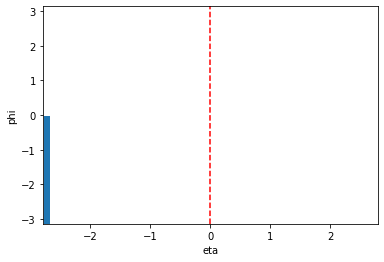

In [104]:
figs[2]

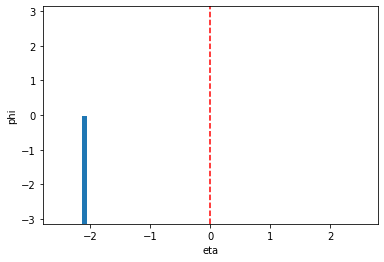

In [102]:
figs[16]

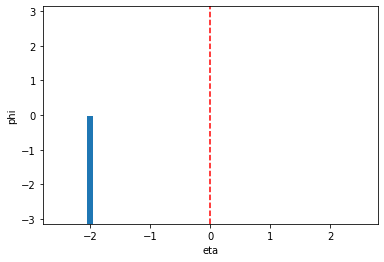

In [103]:
figs[18]